In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [2]:
pickle_off = open ("return_1d.pkl", "rb")
return_1d = pickle.load(pickle_off)
return_1d.head()

,Nifty_50_1d_return,Dow_Jons_1d_return,SPX_500_1d_return,NASDAQ_1d_return,BRENT_1d_return,BOND_10Y_1d_return,Gold_1d_return,Inr_Usd_1d_return,Dollar_Index_1d_return,Bank_Nifty_1d_return,Nifty_IT_1d_return,Nifty_Auto_1d_return,Nifty_Metal_1d_return,Nifty_FMGC_1d_return,Nifty_Energy_1d_return,NIFTY_FIN_SERVICE_1d_return,Nifty_Infra_1d_return,Nifty_CMDT_1d_return,Nifty_Consumer_1d_return
Date,,,,,,,,,,,,,,,,,,,
08-09-11,-0.53,-1.42,-1.37,-1.26,-1.42,-1.81,-1.74,-1.00,-2.71,-0.70,8.26,0.42,-1.46,-0.27,-0.34,-1.00,-0.83,-0.81,-1.19
13-09-11,-0.95,-0.36,0.31,0.35,-0.30,1.97,-1.37,0.01,-2.73,-0.80,-1.27,1.72,0.03,-0.86,-1.16,0.42,-0.88,-0.26,0.88
14-09-11,-13.25,2.14,0.48,0.07,-2.42,-0.68,-1.19,-0.43,-0.88,-3.40,3.66,-0.71,-1.07,-91.91,3.21,-0.79,0.02,-1.14,-0.63
15-09-11,-0.13,0.31,0.28,-0.16,4.74,2.96,12.66,-0.67,6.38,0.40,-0.46,-5.15,8.29,-1.20,-0.03,-2.90,-2.51,5.99,-3.54
16-09-11,-0.87,-0.60,-0.67,-0.56,-2.03,-1.12,-1.77,-1.60,-1.58,-0.69,-1.44,-0.69,-0.91,3.86,-0.64,1.62,0.43,-0.60,-1.61


In [3]:
# Add lagged returns as features
return_1d['Nifty_Infra_1d_return'] = return_1d['Nifty_Infra_1d_return'].shift(1)
return_1d['Nifty_50_1d_return_lag1'] = return_1d['Nifty_50_1d_return'].shift(1)
return_1d = return_1d.dropna()
return_1d['return_squared'] = return_1d['Nifty_Infra_1d_return'] ** 2
return_1d['return_lag_interaction'] = return_1d['Nifty_Infra_1d_return'] * return_1d['Nifty_50_1d_return_lag1']
# Detect and remove outliers using IQR
q1 = return_1d['Nifty_Infra_1d_return'].quantile(0.25)
q3 = return_1d['Nifty_Infra_1d_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1d = return_1d[(return_1d['Nifty_Infra_1d_return'] >= lower_bound) & (return_1d['Nifty_Infra_1d_return'] <= upper_bound)]
np.random.seed(42)

In [4]:
# Display the cleaned data
print("Cleaned data:")
print(return_1d.head())

Cleaned data:
          Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
Date                                                                  
13-09-11               -0.95               -0.36               0.31   
14-09-11              -13.25                2.14               0.48   
15-09-11               -0.13                0.31               0.28   
16-09-11               -0.87               -0.60              -0.67   
19-09-11               -7.11               -2.41              -2.72   

          NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  \
Date                                                              
13-09-11              0.35            -0.30                1.97   
14-09-11              0.07            -2.42               -0.68   
15-09-11             -0.16             4.74                2.96   
16-09-11             -0.56            -2.03               -1.12   
19-09-11             -1.62             0.01               13.07   

          Gold_1d_

In [5]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1d.describe())

Statistics of the cleaned data:
       Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
count         1811.000000         1811.000000        1811.000000   
mean            -1.495400           -3.798421           0.242772   
std             74.313684          107.312768          42.989233   
min          -2807.010000        -3606.010000        -363.000000   
25%             -1.930000           -1.895000          -2.030000   
50%             -0.900000           -1.000000          -1.000000   
75%              0.245000           -0.035000          -0.115000   
max            904.410000          569.550000        1128.740000   

       NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  Gold_1d_return  \
count       1811.000000      1811.000000         1811.000000     1811.000000   
mean          -2.706068        -2.091784           -0.954776       -0.792380   
std           64.794608        22.509688            2.291068       12.187234   
min        -1517.720000      -426.1

In [6]:
# Correlation analysis
corr_matrix_1d = return_1d.corr()
nifty_corr_1d = pd.DataFrame(return_1d.corr()['Nifty_Infra_1d_return'].sort_values())
nifty_corr_1d

,Nifty_Infra_1d_return
return_squared,-0.550969
SPX_500_1d_return,-0.058284
NASDAQ_1d_return,-0.040414
Nifty_Auto_1d_return,-0.030261
Gold_1d_return,-0.023754
Nifty_Metal_1d_return,-0.020705
NIFTY_FIN_SERVICE_1d_return,-0.018227
Inr_Usd_1d_return,-0.017873
Dollar_Index_1d_return,-0.012925
BOND_10Y_1d_return,-0.008359


<Axes: >

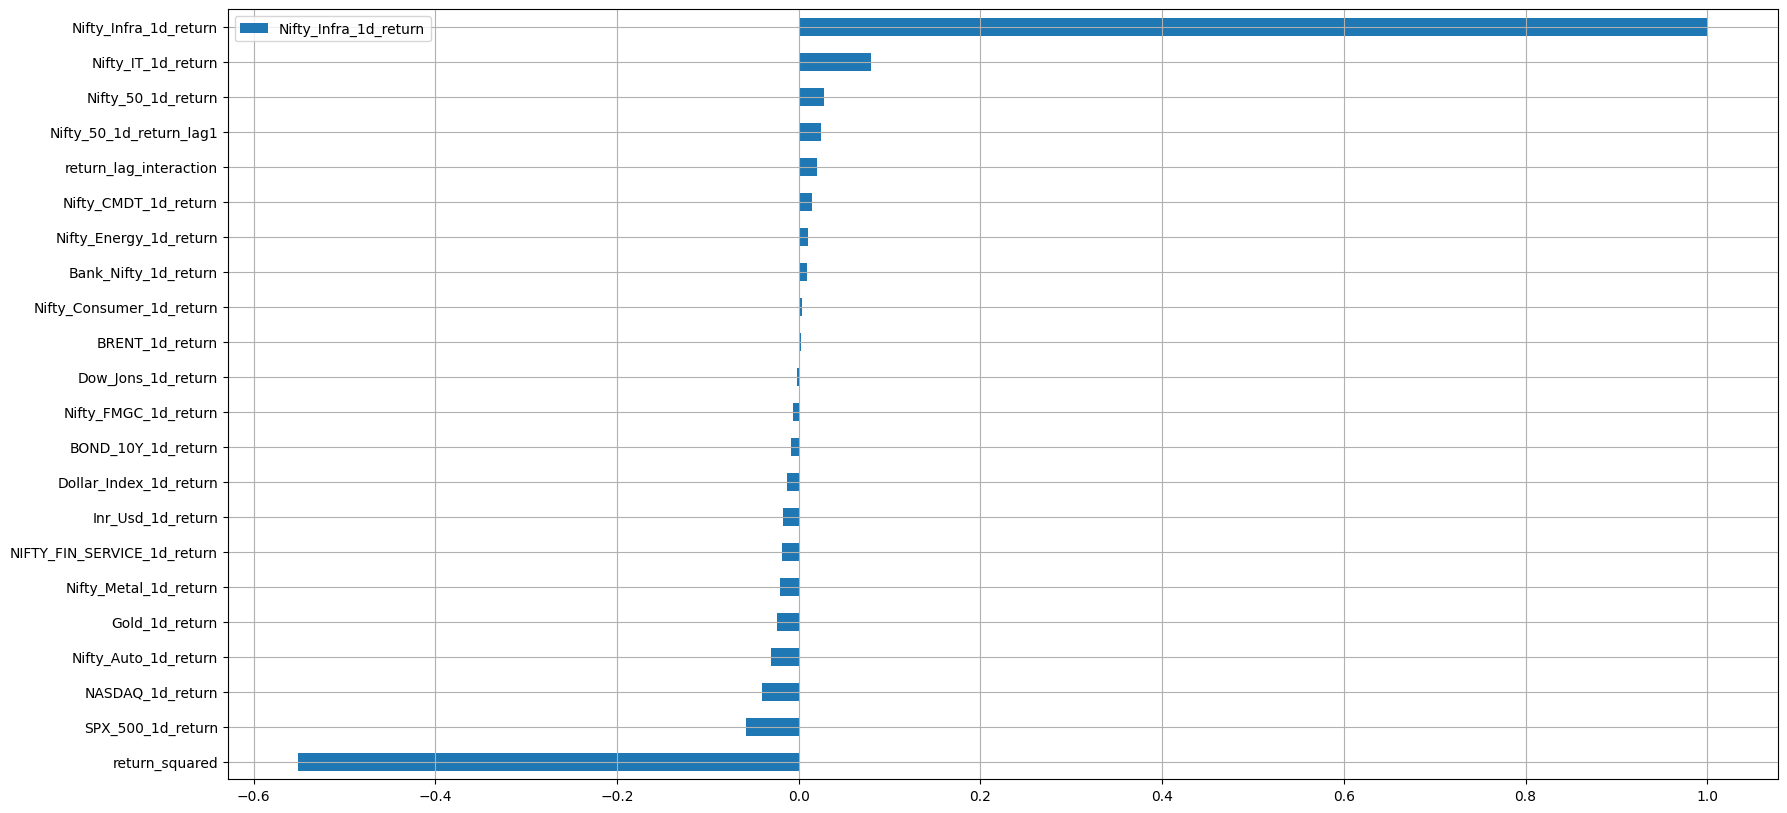

In [7]:
filter = np.abs(nifty_corr_1d)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1d[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [8]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k='all')
X = return_1d.drop(columns='Nifty_Infra_1d_return')
y = return_1d['Nifty_Infra_1d_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['Nifty_50_1d_return', 'Dow_Jons_1d_return', 'SPX_500_1d_return',
       'NASDAQ_1d_return', 'BRENT_1d_return', 'BOND_10Y_1d_return',
       'Gold_1d_return', 'Inr_Usd_1d_return', 'Dollar_Index_1d_return',
       'Bank_Nifty_1d_return', 'Nifty_IT_1d_return', 'Nifty_Auto_1d_return',
       'Nifty_Metal_1d_return', 'Nifty_FMGC_1d_return',
       'Nifty_Energy_1d_return', 'NIFTY_FIN_SERVICE_1d_return',
       'Nifty_CMDT_1d_return', 'Nifty_Consumer_1d_return',
       'Nifty_50_1d_return_lag1', 'return_squared', 'return_lag_interaction'],
      dtype='object')


In [9]:
# Feature Scaling
scaler = StandardScaler()
X = return_1d.drop(columns='Nifty_Infra_1d_return')
y = return_1d['Nifty_Infra_1d_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[-4.00958288e+00  5.37681966e-02 -7.04491703e-03 -1.58070922e-02
   1.32947637e-01 -1.10687433e+00 -4.57670798e-02  4.67263884e-02
   2.81610918e+00 -2.97679136e-01  1.33968638e-02 -1.94131289e-02
  -2.53194720e-02 -2.10009716e-02  4.74789030e+00 -1.07451183e-01
  -5.01916656e-02  9.24168736e-02 -4.28228374e-02  9.66377314e-01
   2.92710959e-02]
 [ 9.62942335e-03 -2.21990083e-02 -4.61004841e-01  1.30850542e-01
  -3.19158051e-02  1.04118931e+00  2.48180527e-02  3.50959481e-01
  -1.22137944e-01 -1.14442443e-02 -1.37654166e-02 -9.09259141e-02
   2.29136890e-02 -2.23690683e-02  3.54143499e-01 -3.36553105e-02
  -2.70893547e-02 -3.73131145e-03 -9.40276085e+00  4.21000589e-01
   9.79027710e+00]
 [ 2.96851043e-02  3.23295989e-02 -2.33325617e-02  2.26326456e-02
   1.20060737e-01 -1.33260119e-01 -1.55748565e-01 -1.50939180e-01
  -8.27064051e-02  2.70713227e-01 -7.66797585e-02  1.85296455e-01
  -3.61010021e-02 -7.70307181e-03 -1.66222973e-03 -4.74274796e-02
  -4.53280212e-02  3.64107335e-03 -3.3

Data Cleaning And Transformation Completed

Model Building for Features Importance

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [12]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [13]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [14]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 0.3576
R2: 0.8133

For RFR:
MSE: 0.1202
R2: 0.9373

For ETR:
MSE: 0.7137
R2: 0.6275

For GBR:
MSE: 0.2154
R2: 0.8876

For XGBR:
MSE: 0.0771
R2: 0.9598



In [15]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is XGBR with an MSE of 0.0771.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, ...)

The best model is XGBR with an MSE of 0.0771.

In [16]:
y_pred = etr.predict(X_test)
df_1d = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df_1d

,Actual,Predicted
Date,,
30-09-20,-0.33,-0.1082
03-02-12,0.57,0.0328
31-03-21,0.24,0.0812
29-09-21,-0.87,-0.3424
27-04-23,-0.39,-0.0508
...,...,...
14-06-13,-0.43,-0.3694
16-09-22,-2.44,-1.8906
12-06-17,-1.94,-1.8692


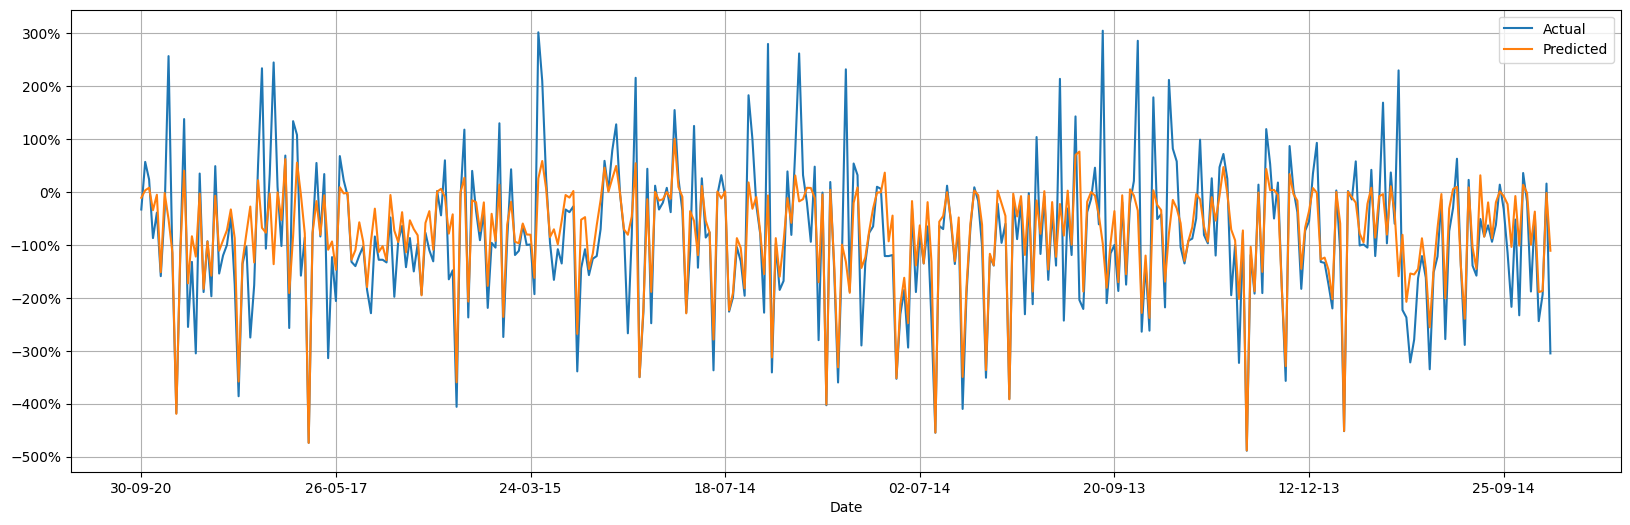

In [17]:
ax = df_1d.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_16004\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_Infra_1d_return', ylabel='Density'>

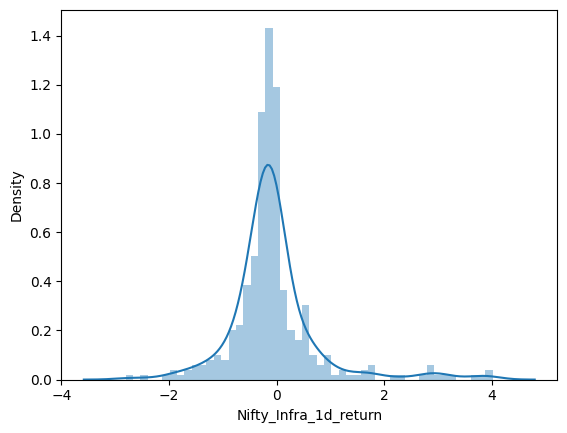

In [18]:
sns.distplot(y_test-y_pred)

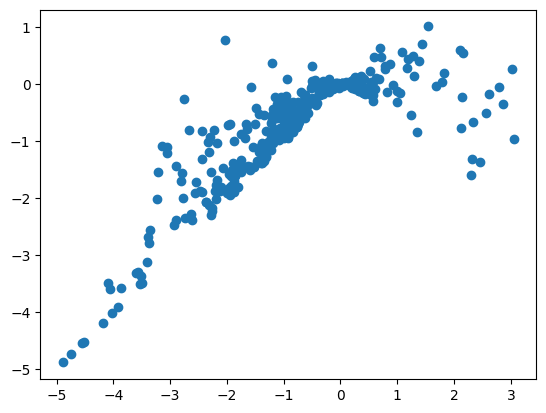

In [19]:
plt.scatter(y_test,y_pred)
